Functional First Dry Run:


### Inputs

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/prepped.zip -d /content/

Archive:  /content/gdrive/MyDrive/prepped.zip
   creating: /content/prepped/
  inflating: /content/prepped/xydata_20211021_023153_3620110077.npz  
  inflating: /content/prepped/xydata_20171111_012544_3610108077.npz  
  inflating: /content/prepped/xydata_20220730_012426_3620108076.npz  
  inflating: /content/prepped/xydata_20200805_124938_3620108077.npz  
  inflating: /content/prepped/xydata_20211025_013431_3620112077.npz  
  inflating: /content/prepped/xydata_20180116_235048_3610108077.npz  
  inflating: /content/prepped/xydata_20220406_150859_3620108077.npz  
  inflating: /content/prepped/xydata_20210525_053903_3620110077.npz  
  inflating: /content/prepped/xydata_20210329_053958_3620110077.npz  
  inflating: /content/prepped/xydata_20200817_001801_3620110077.npz  
  inflating: /content/prepped/xydata_20220410_151631_3620108077.npz  
  inflating: /content/prepped/xydata_20190814_121420_3620112077.npz  
  inflating: /content/prepped/xydata_20191208_124810_3610108077.npz  
  inflating: 

In [ ]:
# import os
# to_remove = os.listdir('/content/dataset/fixing_dataset')
# aba = []
# for i in to_remove:
#   aba.append('/content/dataset/fixing_dataset/'+i)
# # print(*aba), !rm

### Loading Data + Normalizing Outliers

In [ ]:
X = []
Y = []

In [ ]:
!rm dataset/fixing_dataset/.DS_Store

rm: cannot remove 'dataset/fixing_dataset/.DS_Store': No such file or directory


In [ ]:
import os
path = '/content/prepped/'

for s in os.listdir(path):
  obs = np.load(path+'/'+s)
  data_x = obs['x']
  data_y = obs['y']
  X.append(np.transpose(data_x, [1, 2, 0]))
  Y.append(data_y)

In [ ]:
X[0].dtype

dtype('float64')

In [ ]:
Y[0].dtype

dtype('float64')

In [ ]:
len(X), len(Y)

(137, 137)

In [ ]:
# for i in range(100):
#   #print(X[i].shape, Y[i].shape)
#   if Y[i].shape[1] == 31:
#     print(i, os.listdir(path)[i])

In [ ]:

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 2, figsize=[10, 8])
# ax[0].imshow(iris)
# ax[1].imshow(unn_iris)

### Data Augmentation

In [ ]:
from skimage.transform import resize
from skimage import data

#X = [resize(image, target_size) for image in X]
# test_x = X[0]
# test_y = Y[0]

In [ ]:
print(np.unique([a.shape for a in X]))

[  3 165 180 186 198 199 289 290 291]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

In [ ]:
x_train, x_test, y_train, y_test = np.asarray(x_train, dtype = object), np.asarray(x_test, dtype = object), np.asarray(y_train, dtype = object), np.asarray(y_test, dtype = object)

In [ ]:
print(len(x_train))
print(len(y_train))

109
109


### Custom Data Generator

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, Y, target_size, batch_size):
        self.X = X
        self.Y = Y
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return int(len(self.X) / self.batch_size)

    def __getitem__(self, index):
        batch_X = self.X[index*self.batch_size : (index+1)*self.batch_size]
        batch_Y = self.Y[index*self.batch_size : (index+1)*self.batch_size]

        # Preprocess and generate data for the batch
        processed_X = np.asarray(self.preprocess_X(batch_X))
        processed_Y = np.asarray(self.preprocess_Y(batch_Y))

        #print(processed_X.shape)

        return processed_X, processed_Y

    def preprocess_X(self, batch_X):
        # Implement preprocessing logic for input data (X)
        # Return processed input data

        # Padding

        #print(batch_X[0].shape)
        padded = [self.padding_rgb(x) for x in batch_X]
        return padded

        pass

    def preprocess_Y(self, batch_Y):
        # Implement preprocessing logic for target data (Y)
        # Return processed target data
        padded = [self.padding_bw(y) for y in batch_Y]

        return padded

        pass

    def padding_rgb(self, image):
        #print("HERE", image.shape)

        ih, iw, c = image.shape
        fh, fw = self.target_size
        blank = (0,0,0)
        result = np.full((fh, fw, c), blank, dtype=np.float32)
        #print("checkpoint 1", result.dtype)

        x_center = (fw - iw) // 2
        y_center = (fh - ih) // 2

        result[y_center:y_center+ih,
              x_center:x_center+iw] = image

        return result
        pass

    def padding_bw(self, image):
        ih, iw = image.shape
        fh, fw = self.target_size
        blank = 0
        result = np.full((fh,fw), blank, dtype=np.float32)
        #print("checkpoint 2", result.dtype)

        x_center = (fw - iw) // 2
        y_center = (fh - ih) // 2

        result[y_center:y_center+ih,
              x_center:x_center+iw] = image

        return result
        pass

    def on_epoch_end(self):
        # Optional method to perform any action at the end of each epoch
        pass

In [ ]:
max_x = np.nanmax([a.shape[1] for a in X])
max_y = np.nanmax([a.shape[0] for a in X])
target_size = (max_y, max_x)


batch_size = 16


train_gen = DataGenerator(X = x_train, Y = y_train, target_size = target_size, batch_size = batch_size)
test_gen = DataGenerator(X = x_test, Y = y_test, target_size = target_size, batch_size = batch_size)

### Custom Loss Function
- MSE for now

In [ ]:
import keras.backend as K

def loss(y_true, y_pred):

  mse = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)

  return mse

### Building Model

In [ ]:

from keras.models import Sequential
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.layers import *
from keras import optimizers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers

In [ ]:
def build_model(target_size = target_size):
  model = Sequential()
  input_shape = [target_size[0], target_size[1], 3]
  model.add(Conv2D(16, (5, 5), input_shape=input_shape, activation='relu', padding = 'same'))
  model.add(Conv2D(32, (5, 5), activation='relu', padding = 'same'))
  model.add(Conv2D(64, (5, 5), activation='relu', padding = 'same'))
  model.add(Conv2D(1, (1, 1)))
  #model.add(Reshape((198, 186)))
  model.compile(loss=loss, optimizer=optimizers.Adam(learning_rate = 0.0001, amsgrad=True), metrics=[loss, 'accuracy'] )
  return model

In [ ]:
model = build_model(target_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 291, 186, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 291, 186, 32)      12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 291, 186, 64)      51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 291, 186, 1)       65        
                                                                 
Total params: 65,377
Trainable params: 65,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 291, 186, 3) <dtype: 'float32'>
(None, 291, 186, 1) <dtype: 'float32'>
conv2d (None, 291, 186, 3) float32
conv2d_1 (None, 291, 186, 16) float32
conv2d_2 (None, 291, 186, 32) float32
conv2d_3 (None, 291, 186, 64) float32


[None, None, None, None]

In [ ]:
# test_x.shape, test_y.shape

In [ ]:
# np.asarray([test_x]).shape

In [ ]:
from keras.callbacks import History
history = History()
model.fit(train_gen, steps_per_epoch = len(train_gen), validation_data = test_gen, validation_steps = len(test_gen), epochs = 30, use_multiprocessing = True, callbacks = [history])

Epoch 1/30
6/6 [==============================] - 94s 16s/step - loss: 11054.7998 - accuracy: 0.0841 - val_loss: 6418.9502 - val_accuracy: 0.1239
Epoch 2/30
6/6 [==============================] - 80s 13s/step - loss: 4054.2778 - accuracy: 0.0763 - val_loss: 1892.5206 - val_accuracy: 0.1218
Epoch 3/30
6/6 [==============================] - 79s 13s/step - loss: 1434.0226 - accuracy: 0.0758 - val_loss: 1262.7627 - val_accuracy: 0.1218
Epoch 4/30
6/6 [==============================] - 80s 13s/step - loss: 1832.3558 - accuracy: 0.0758 - val_loss: 1298.1487 - val_accuracy: 0.1218
Epoch 5/30
6/6 [==============================] - 122s 20s/step - loss: 1403.3384 - accuracy: 0.0758 - val_loss: 1078.5005 - val_accuracy: 0.1218
Epoch 6/30
6/6 [==============================] - 102s 18s/step - loss: 1316.5365 - accuracy: 0.0758 - val_loss: 1326.1112 - val_accuracy: 0.1218
Epoch 7/30
6/6 [==============================] - 102s 18s/step - loss: 1326.7257 - accuracy: 0.0758 - val_loss: 1178.3134 - va

In [ ]:
score = model.evaluate(test_gen, verbose = 0, use_multiprocessing = True)
score

# print("Test Loss: ", score[0])
# print("Test Accuracy: ", score[1]) #not sure why they are the same?

[1012.58837890625, 1012.58837890625, 0.12860962748527527]

### Data Visualization

In [ ]:
predictions = model.predict(test_gen, steps = len(test_gen))

1/1 [==============================] - 4s 4s/step


In [ ]:
len(predictions)

16

In [ ]:
inputs = []
corrects = []

for i in range(len(predictions)):
  input = []
  if i < 16:
    for j in range(3):
      input.append(test_gen.__getitem__(0)[0][i,:,:,j])

    inputs.append(input)
    corrects.append(test_gen.__getitem__(0)[1][i,:,:])
  else:
    print("HERE")
    for j in range(3):
      input.append(test_gen.__getitem__(1)[0][i-16,:,:,j])

    inputs.append(input)
    corrects.append(test_gen.__getitem__(1)[1][i-16,:,:])

In [ ]:
np.nanmax(predictions[i])

284.33768

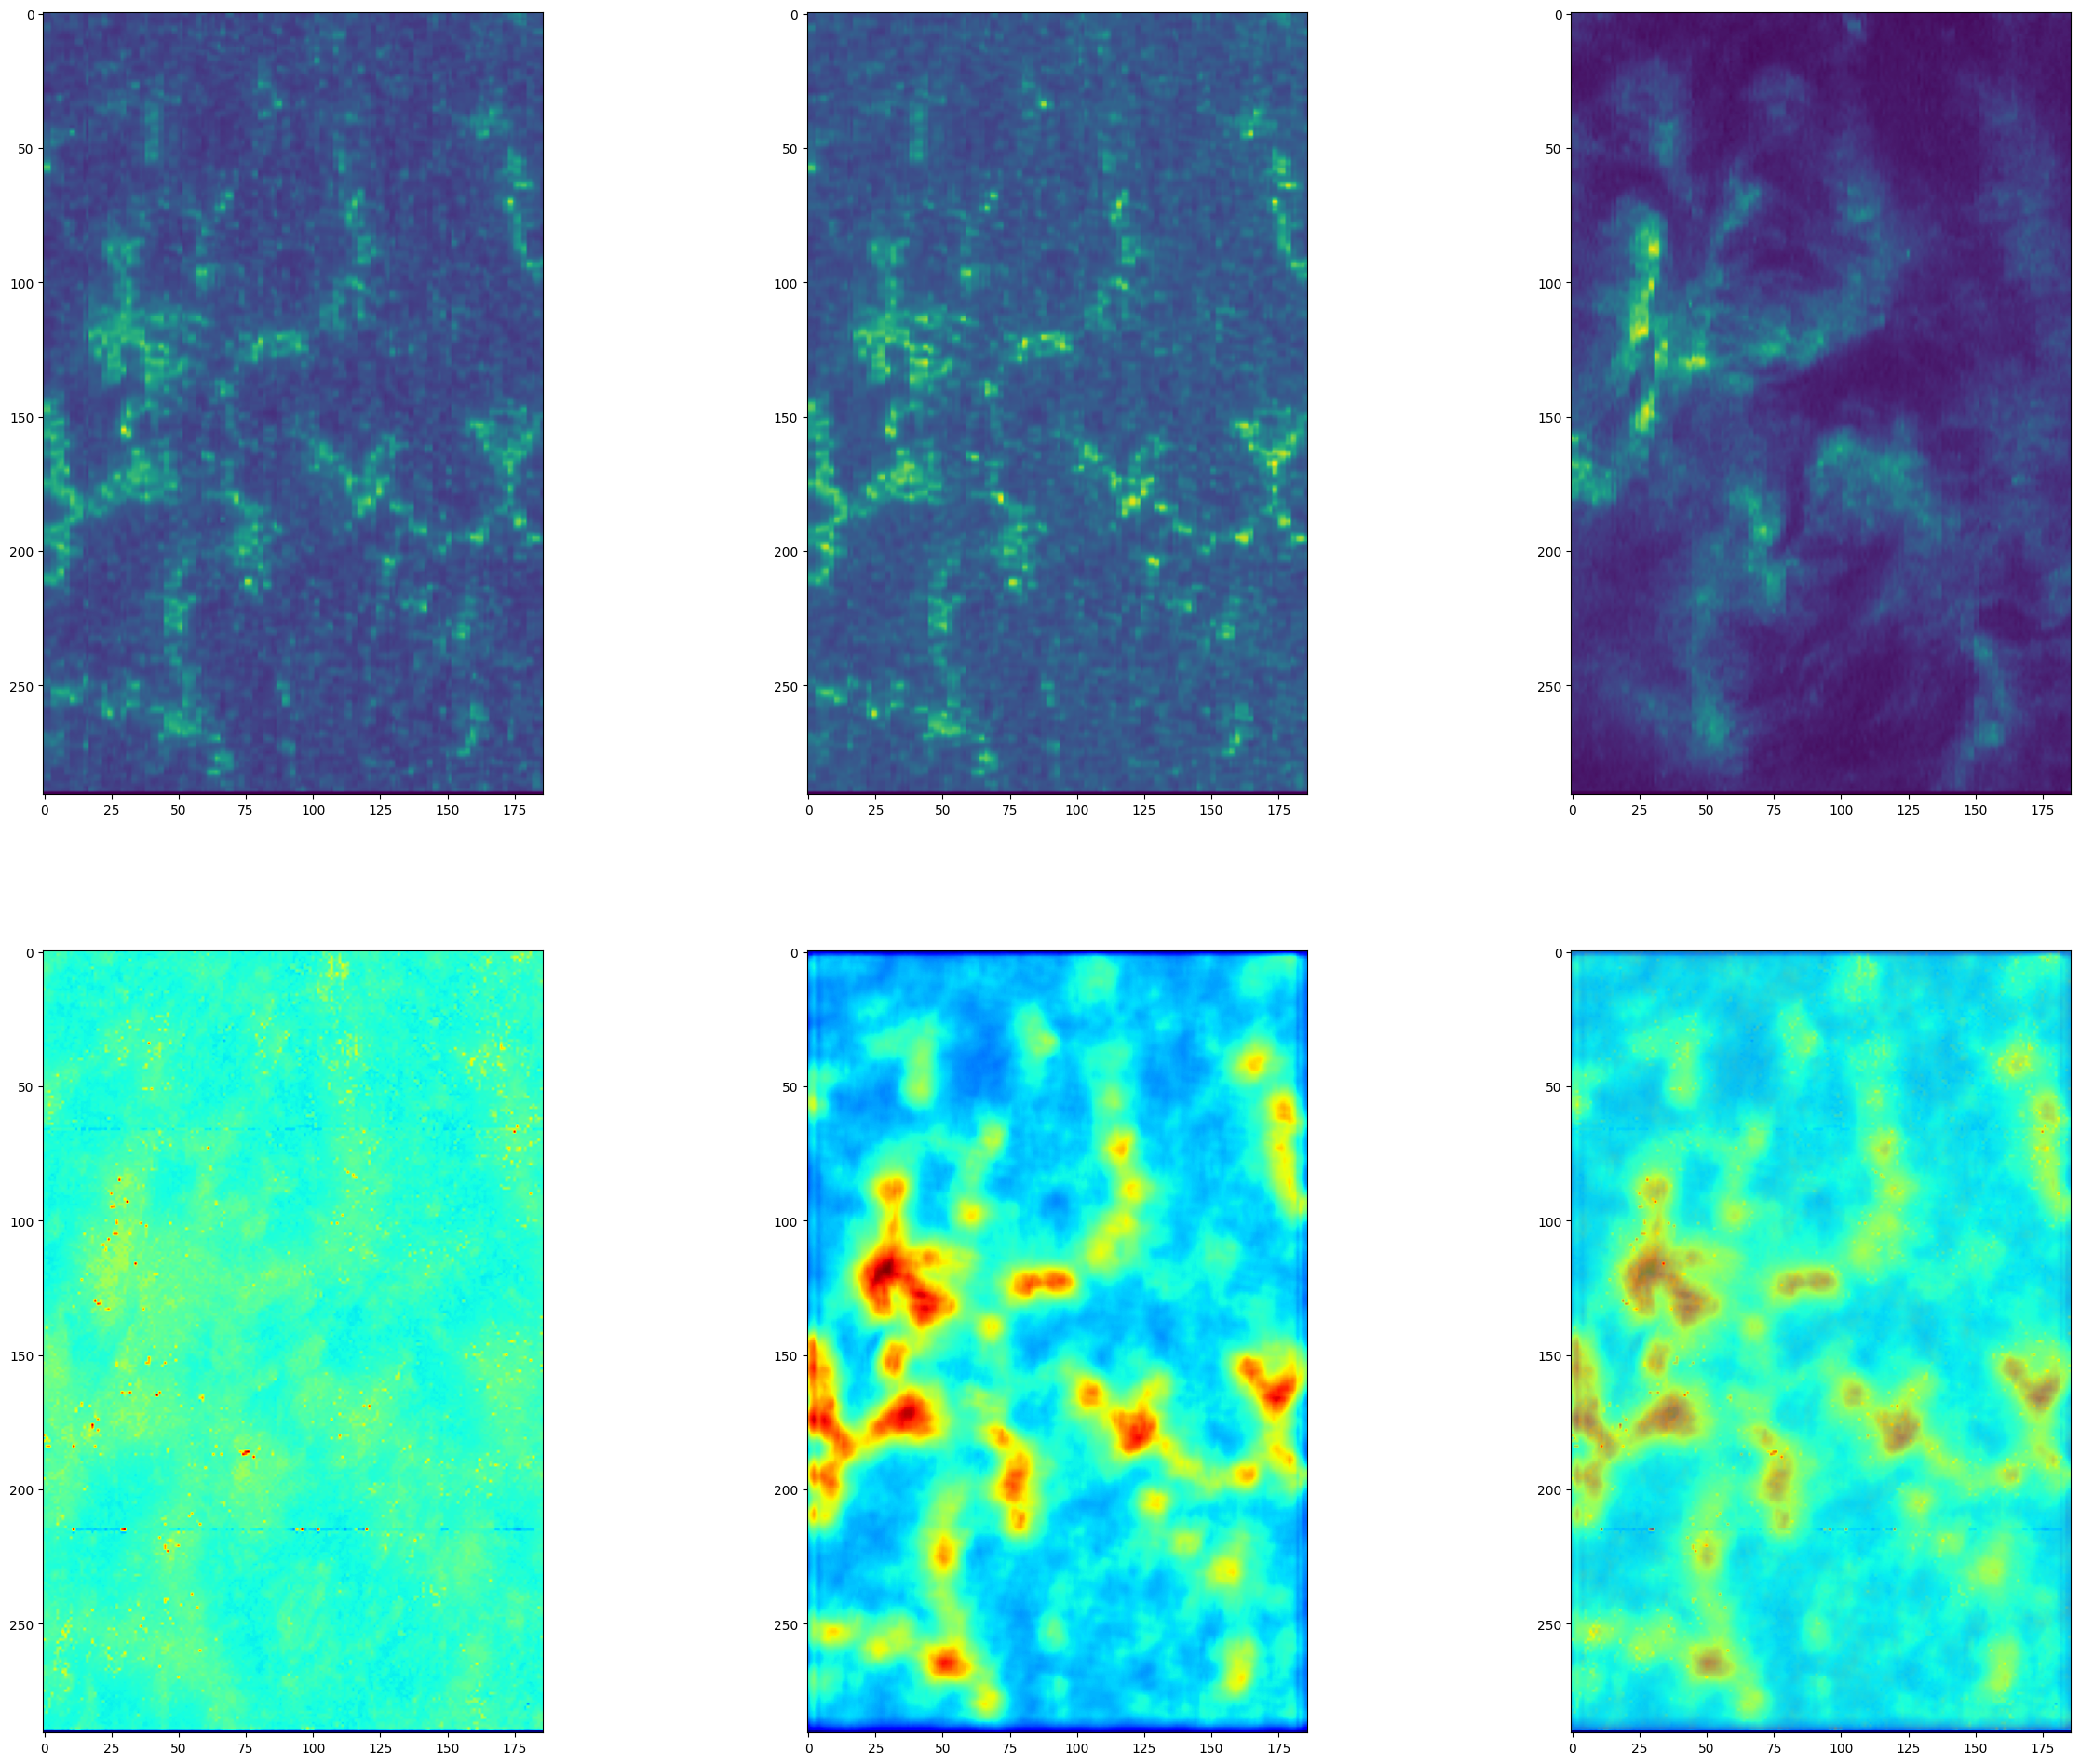

In [ ]:
i = 15

fig, ax = plt.subplots(2, 3, figsize = [30,24])
ax[0][0].imshow(inputs[i][0]) #1600
ax[0][1].imshow(inputs[i][1]) #1700
ax[0][2].imshow(inputs[i][2]) #304
ax[1][0].imshow(corrects[i], cmap='jet') #temperature
ax[1][1].imshow(predictions[i], cmap = 'jet') #predicted

#overlayed predicted and correct temp
ax[1][2].imshow(corrects[i], cmap = 'jet'); ax[1][2].imshow(predictions[i], alpha = 0.5*(corrects[i]>0), cmap = 'jet')

In [ ]:
i = 15

data_cube = [inputs[i][0],inputs[i][1],inputs[i][2],corrects[i],predictions[i][:,:,0]]
to_save = np.stack(tuple(data_cube))
np.savez('/content/output/ahh.npz', data = to_save)

FileNotFoundError: ignored

### 6/15 Meeting Prep

In [ ]:
history.history.keys()

In [ ]:
plt.plot(range(30), history.history['loss'], 'r')
plt.plot(range(30), history.history['val_loss'], 'b')
# plt.plot(range(30), history.history['accuracy'], 'g')
# plt.plot(range(30), history.history['val_accuracy'], 'purple')
# plt.legend(['Loss', 'Validation Loss', 'Accuracy', 'Validation Accuracy'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

### K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import History
folds = 5

kf = KFold(n_splits = folds)
histories = []


for train_index, test_index in kf.split(X):
  x_train, x_test = [X[train_ind] for train_ind in train_index], [X[test_ind] for test_ind in test_index]
  y_train, y_test = [Y[train_ind] for train_ind in train_index], [Y[test_ind] for test_ind in test_index]
  traingen = DataGenerator(X = x_train, Y = y_train, target_size = target_size, batch_size = batch_size)
  testgen = DataGenerator(X = x_test, Y = y_test, target_size = target_size, batch_size = batch_size)
  model = build_model()
  history = History()
  model.fit(traingen, steps_per_epoch = len(traingen), validation_data = testgen, validation_steps = len(testgen), epochs = 30, use_multiprocessing = True, callbacks = [history])
  histories.append(history)

Epoch 1/30
6/6 [==============================] - 84s 13s/step - loss: 8983.4912 - accuracy: 0.0851 - val_loss: 5236.0977 - val_accuracy: 0.0727
Epoch 2/30
6/6 [==============================] - 79s 14s/step - loss: 3784.6326 - accuracy: 0.0841 - val_loss: 1612.2950 - val_accuracy: 0.0726
Epoch 3/30
6/6 [==============================] - 79s 13s/step - loss: 1388.6683 - accuracy: 0.0840 - val_loss: 2225.2043 - val_accuracy: 0.0726
Epoch 4/30
6/6 [==============================] - 89s 15s/step - loss: 1841.5885 - accuracy: 0.0840 - val_loss: 2098.5847 - val_accuracy: 0.0726
Epoch 5/30
6/6 [==============================] - 82s 13s/step - loss: 1395.1385 - accuracy: 0.0840 - val_loss: 1364.4736 - val_accuracy: 0.0726
Epoch 6/30
6/6 [==============================] - 84s 14s/step - loss: 1314.3582 - accuracy: 0.0840 - val_loss: 1349.0669 - val_accuracy: 0.0726
Epoch 7/30
6/6 [==============================] - 81s 13s/step - loss: 1335.8085 - accuracy: 0.0840 - val_loss: 1307.0101 - val_ac

In [ ]:
losses = []
val_losses = []

for history in histories:
  losses.append(history.history['loss'])
  val_losses.append(history.history['val_loss'])

Text(0, 0.5, 'Loss')

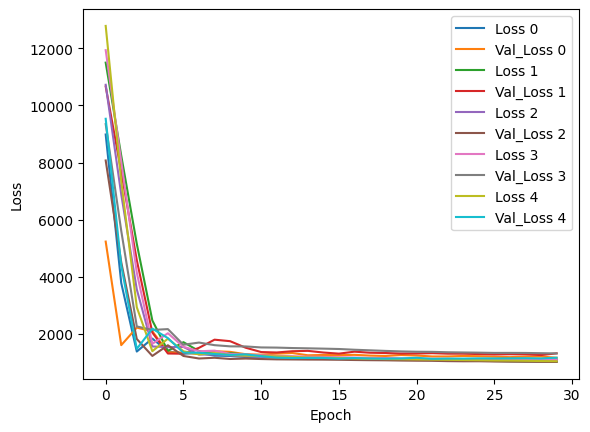

In [ ]:
leg = []

for i, history in enumerate(histories):
  plt.plot(range(30), losses[i])
  plt.plot(range(30), val_losses[i])
  leg.append('Loss {}'.format(i))
  leg.append('Val_Loss {}'.format(i))

plt.legend(leg)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
losses[1] # fold with smallest ending loss

[11497.478515625,
 8243.7255859375,
 5157.76611328125,
 2475.0751953125,
 1412.5694580078125,
 1715.8763427734375,
 1404.560546875,
 1307.6563720703125,
 1334.1986083984375,
 1277.94677734375,
 1239.030517578125,
 1227.45263671875,
 1198.2857666015625,
 1184.0272216796875,
 1165.5806884765625,
 1158.7918701171875,
 1147.0943603515625,
 1135.233642578125,
 1121.03955078125,
 1111.3685302734375,
 1100.3173828125,
 1091.4130859375,
 1080.85986328125,
 1072.1790771484375,
 1063.313232421875,
 1057.19189453125,
 1048.349853515625,
 1041.525634765625,
 1038.758544921875,
 1028.0833740234375]

### GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV
model = create_model()
params = {
    'batch_size': [16, 32],
    'epochs': [10, 20, 30]
}


grid  = GridSearchCV(model, param_grid = params, refit = True, n_jobs = -1)
grid.fit()